## Bayesian parameter estimation using Importance Sampling

In this notebook we illustrate another way to sample from a posterior pdf, that is, using importance sampling. One samples from a proposal distribution, then the samples are weighted to account for the discrepancy between the proposal pdf and the target posterior pdf. The BayesParameterEstimation class using IS returns samples from the proposal and weigths for each sample. If one requires a set of un-weighted samples, one can use the resample function from UQpy.Utilities. This notebook also illustrates the use of simple diagnostics for IS.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate
from UQpy.Utilities import diagnostics

## Probability model

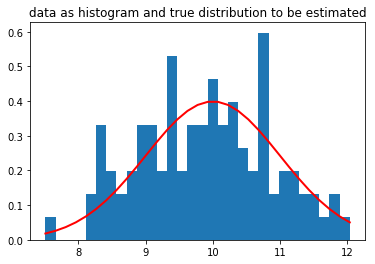

In [12]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [13]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal', n_params=2,
                        prior_name = ['uniform','lognormal'], prior_params = [[0, 15], [1, 0, 1]])

In [14]:
# Learn the unknown parameters using IS
bayes_estimator = BayesParameterEstimation(model=candidate_model, data=data, sampling_method = 'IS', nsamples=10000)

UQpy: Parameter estimation analysis completed!


1.0


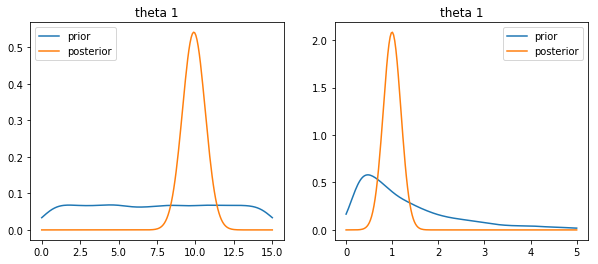

In [15]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2,figsize=(10,4))

domain = np.linspace(0, 15, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='prior')
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=w)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='posterior')
ax[0].legend()
ax[0].set_title('theta 1')

domain = np.linspace(0, 5, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='prior')
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=w)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='posterior')
ax[1].legend()
ax[1].set_title('theta 1')

plt.show()

## Regression model - $y=X \theta + \epsilon$

In [ ]:
# Generate data from a quadratic equation, add some noise to it
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_1', 'theta_2'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

In [ ]:
candidate_model = Model(n_params=2, model_type='python',
                        model_script='pfn_models.py', model_object_name = 'model_quadratic', 
                        error_covariance=error_covariance)

In [ ]:
bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, sampling_method='IS', nsamples=200000,
                                           pdf_proposal=['normal','normal'], pdf_proposal_params=[[0, 2], [0, 2]])

In [ ]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2)
for i in range(2):
    ax[i].hist(x=s[:,i], weights=None, density=True, range=(-4, 4), bins = 20, color='blue', alpha=0.4, label='prior')
    ax[i].hist(x=s[:,i], weights=w, density=True, range=(-4, 4), bins = 20, color='orange', alpha=0.7, label='posterior')
    ax[i].legend()
    ax[i].set_title('theta {}'.format(i+1))

plt.show()

In [ ]:
diagnostics(sampling_method='IS', sampling_outputs = bayes_estimator)

In this example, the effective sample size is about 20 samples, out of a total of 20000 samples that were generated and evaluated. A pdf approximation based on 20 samples only is likely to be very poor. Methods to guide the choice of proposal pdf will be released in future versions of UQpy.